### Define your license plate file

In [1]:
src="img/0_4932XX_1.jpg"

### FFT rectify main program

180
(186, 144)
61


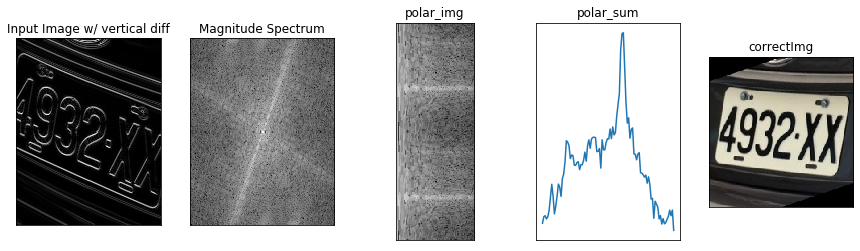

187
(179, 150)
54


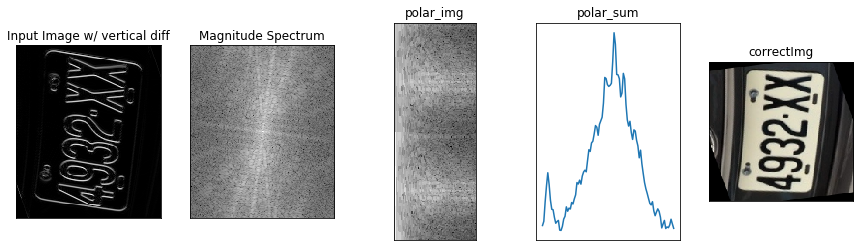

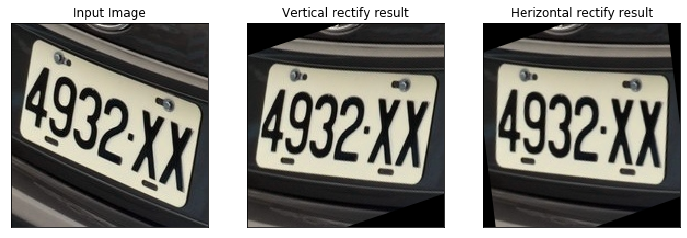

In [2]:
import os, sys
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2
import time
import statistics

isPlot=True
isBias=False
coreCut=0.01
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def fftplot(imgPath):
    img = cv2.imread(imgPath)
    pix_color = np.array(img)
    img = rgb2gray(pix_color)
    #print(img.shape)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def imgWrapA(orgImg,a):
    column=orgImg.shape[1]
    row=orgImg.shape[0]
    #plt.plot( int(column/2),int(row/2),'rx')#fix
    #plt.plot( int(column/2),int(row/4),'bx')#fix
    #plt.plot( int(column/4),int(row/2-column/4*a),'go')#offset
    pts1 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2-column/4*a]])
    pts2 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2]])
    M = cv2.getAffineTransform(pts1,pts2)
    imgWarpAffine = cv2.warpAffine(orgImg,M,(column,row))
    return imgWarpAffine

def estCorrect(orgImg0, cutoffF=0.8, margin=0.1):
    orgImg = cv2.fastNlMeansDenoisingColored(orgImg0,None,9,9,7,21)
    w=orgImg.shape[1]
    print(w)
    crop_img = orgImg[:, int(margin*w):int(w-margin*w)]
    pix_color = np.array(crop_img)
    full_pix_color = np.array(orgImg)
    img = rgb2gray(pix_color)
    img=abs(img[0:-1,:]-img[1:,:])
    
    print(img.shape)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
        
    #plt.subplot(143),plt.imshow(np.abs(fshift), cmap = 'gray')
    #plt.title('np.abs(fshift)'), plt.xticks([]), plt.yticks([])
    margin = 0.9 # Cut off the outer 10% of the image
    # Do the polar rotation along 100 angular steps with a radius of 256 pixels.
    size=min(img.shape)
    polar_img = cv2.warpPolar(magnitude_spectrum, (int(size/2), 200), (img.shape[1]/2,img.shape[0]/2), 
                                  size*margin*0.5, cv2.WARP_POLAR_LINEAR)
    #print(polar_img.shape)

    polar_img_lowF=polar_img[:,int(coreCut*polar_img.shape[1]):int(cutoffF*polar_img.shape[1])]
    
    polar_sum_200=np.sum(polar_img_lowF,axis=1)
    polar_sum=polar_sum_200[0:100]+polar_sum_200[100:200]
    #polar_sum[50]=min(polar_sum) #matthew  do not count center line
    #print(statistics.stdev(polar_sum[25:75]))
    gainStdev=statistics.stdev(polar_sum[25:75])/10000
    if isBias:
        polar_sum[45:56]=(polar_sum[45:56]*GAIN*gainStdev+polar_sum[45:56]*(1-gainStdev))
    maxIndex=np.argmax(polar_sum[25:75])+25
    print(maxIndex)
    offsetDegree=(maxIndex-50)/100*3.14
    aEst=np.sin(offsetDegree)
    #correctImg=imgWrapA(pix_color,aEst)
    full_pix_color0 = np.array(orgImg0)
    correctImg=imgWrapA(full_pix_color0,aEst)
    #full_pix_color
    #polar_sum[25:75]=min(polar_sum) #matthew  do not count center line
    #maxIndex2=np.argmax(polar_sum)
    #print("maxIndex2={}".format(maxIndex2))
    
    if isPlot:
        plt.subplots(1,4,figsize=(15,4))
        plt.subplot(151),plt.imshow(img, cmap = 'gray')
        plt.title('Input Image w/ vertical diff'), plt.xticks([]), plt.yticks([])
        plt.subplot(152),plt.imshow(magnitude_spectrum, cmap = 'gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.subplot(153),plt.imshow(polar_img, cmap = 'gray')
        plt.title('polar_img'), plt.xticks([]), plt.yticks([])
        plt.subplot(154),plt.plot(polar_sum)
        #print(polar_sum-min(polar_sum))
        plt.title('polar_sum'), plt.xticks([]), plt.yticks([])
        plt.subplot(155),plt.imshow(correctImg)
        plt.title('correctImg'), plt.xticks([]), plt.yticks([])
        plt.show()
    return correctImg

def estCorrect2D(orgImg, cutoffF=0.8, margin=0.1):
    hCorrectedImg=estCorrect(orgImg, cutoffF, margin)
    hCorrectedImg90=np.rot90(hCorrectedImg, )
    vCorrectedImg=estCorrect(hCorrectedImg90, cutoffF, margin)
    vCorrectedImg270=np.rot90(vCorrectedImg,  k=3)
    if isPlot:
        plt.subplots(1,3,figsize=(12,4))
        plt.subplot(131),plt.imshow(orgImg)
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(hCorrectedImg)
        plt.title('Vertical rectify result'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(vCorrectedImg270)
        plt.title('Horizontal rectify result'), plt.xticks([]), plt.yticks([])
        plt.show()
        
    
    return hCorrectedImg, vCorrectedImg270


def fftplotWarp(imgPath):
    orgImg = cv2.imread(imgPath)
    pix_color = np.array(orgImg)
    hCorrectedImg, CorrectedImg=estCorrect2D(pix_color, 0.8, 0.1)

        
fftplotWarp(src)
